Introduction

Hi, my name is Kuni and I am a big fan of data analysis and data science. Today I am doing analysis and prediction on Singapore resale HDB price. The main content is as follow:

Data wrangling
Data Analysis
Data preparation for Machine Learning (ML) model input
Selecting the best ML model for prediction of Singapore resale HDB price
Case study: how much is the price of resale 4-room HDB in different region of Singapore (Central, East, North, South, and West)

## ---------Prediction of Singapore HDB price_Machine Learning-----------------

#####  Importing necessary libraries 

In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")


### Data Wrangling And  data Preprocessing

##### First, we observe the dataset and determine which dataset is relevant to our analysis.

In [261]:
hdb_df = pd.read_csv(r'C:\Users\hp.MUKESH-LF4B6N6\Downloads\ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

#### Head of the dataset

In [262]:
hdb_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


#### Shape of the dataset


In [263]:
hdb_df.shape

(166049, 11)

#### Info of the dataset

In [264]:
hdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166049 entries, 0 to 166048
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                166049 non-null  object 
 1   town                 166049 non-null  object 
 2   flat_type            166049 non-null  object 
 3   block                166049 non-null  object 
 4   street_name          166049 non-null  object 
 5   storey_range         166049 non-null  object 
 6   floor_area_sqm       166049 non-null  float64
 7   flat_model           166049 non-null  object 
 8   lease_commence_date  166049 non-null  int64  
 9   remaining_lease      166049 non-null  object 
 10  resale_price         166049 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 13.9+ MB


#### drop column ['month','street_name','flat_model','lease_commence_date','block'] in my analysis

In [265]:
# In my analysis, I do not consider street name, block and  flat model is relevant (town is sufficient for analysis, as no description of impact of the address, e.g., near MRT or not). Some information in flat model are either similar to room type (2 room, multi generation, etc.) or it reflected how old the unit is, which can be represented by lease commence date and remaining lease.Therefore. I will drop this column for my analysis
hdb_df = hdb_df.drop(['month','street_name','flat_model','lease_commence_date', 'block'], axis=1)

#### Rename the columns so it will be clearer

In [266]:
# Let's rename the column so it will be clearer
hdb_df = hdb_df.rename(columns={'flat_type':'number_of_rooms','storey_range':'storey'})

##### I assume EXECUTIVE is equal to a 6 room (5 room + 1 study room). MULTI-GENERATION is equal to a 5 room (it served the same purpose).

In [267]:
# I assume EXECUTIVE is equal to a 6 room (5 room + 1 study room). MULTI-GENERATION is equal to a 5 room (it served the same purpose)
hdb_df['number_of_rooms'] = hdb_df['number_of_rooms'].str.replace(r'EXECUTIVE','6 ROOM',regex=True)
hdb_df['number_of_rooms'] = hdb_df['number_of_rooms'].str.replace(r'MULTI-GENERATION','5 ROOM',regex=True)
hdb_df['number_of_rooms'] = hdb_df['number_of_rooms'].str.replace(r'ROOM','',regex=True).astype('int')

In [268]:
# I assume that rather we use floor range, I the possible highest floor within the unit storey range.
hdb_df['storey'] = hdb_df['storey'].str[-2:].astype('int')

In [269]:
# I revise the format of the data in the remaining lease to be quantifiable (change to float).
hdb_df['remaining_lease'] = hdb_df['remaining_lease'].str.split(' ')
hdb_df['remaining_lease'] = hdb_df['remaining_lease'].apply(lambda x: (float(x[0])+(float(x[2])/12)) if (len(x)==4) else float(x[0]))
hdb_df.head()

,town,number_of_rooms,storey,floor_area_sqm,remaining_lease,resale_price
0,ANG MO KIO,2,12,44.0,61.333333,232000.0
1,ANG MO KIO,3,3,67.0,60.583333,250000.0
2,ANG MO KIO,3,3,67.0,62.416667,262000.0
3,ANG MO KIO,3,6,68.0,62.083333,265000.0
4,ANG MO KIO,3,3,67.0,62.416667,265000.0


#### Check the null values in dataset

In [270]:
hdb_df.isna().sum()

town               0
number_of_rooms    0
storey             0
floor_area_sqm     0
remaining_lease    0
resale_price       0
dtype: int64

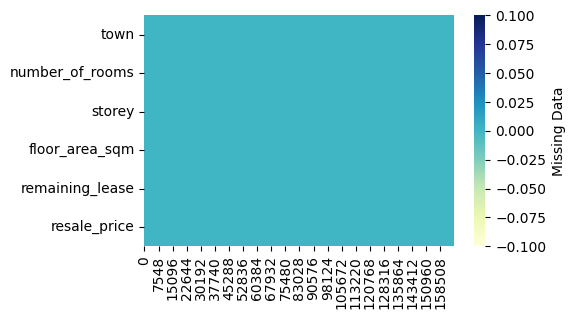

In [271]:
plt.figure(figsize=(5,3))
sns.heatmap(hdb_df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

## Feature Engineering:

In [272]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [273]:
# Assuming 'df' is your DataFrame
df_encoded = pd.get_dummies(hdb_df, columns=['town'], drop_first=True)

In [300]:
# Separate features and target variable
X = hdb_df.drop('resale_price', axis=1)
y = hdb_df['resale_price']

In [301]:
# Identify categorical and numerical features
categorical_features = ['town', 'story']
numerical_features = ['number_of_rooms', 'floor_area_sqm']

In [302]:
categorical_features

['town', 'story']

In [303]:
numerical_features 

['number_of_rooms', 'floor_area_sqm']

In [304]:
# Create transformers for preprocessing
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])


In [305]:
numeric_transformer

Pipeline(steps=[('scaler', StandardScaler())])

In [306]:
categorical_transformer

Pipeline(steps=[('onehot', OneHotEncoder())])

In [307]:
# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [308]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['number_of_rooms', 'floor_area_sqm']),
                                ('cat',
                                 Pipeline(steps=[('onehot', OneHotEncoder())]),
                                 ['town', 'story'])])

##### Create an instance of SimpleImputer with mean strategy

In [309]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean

SimpleImputer()

## HDB Data Analysis

#### Assuming 'hdb_df' is your DataFrame with the 'resale_price' column

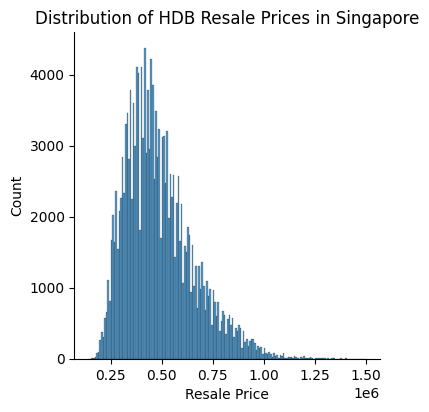

In [274]:
sns.displot(hdb_df['resale_price'], height=4)
plt.title('Distribution of HDB Resale Prices in Singapore')
plt.xlabel('Resale Price')
plt.ylabel('Count')
plt.show()


##### Histogram for 'number_of_rooms'

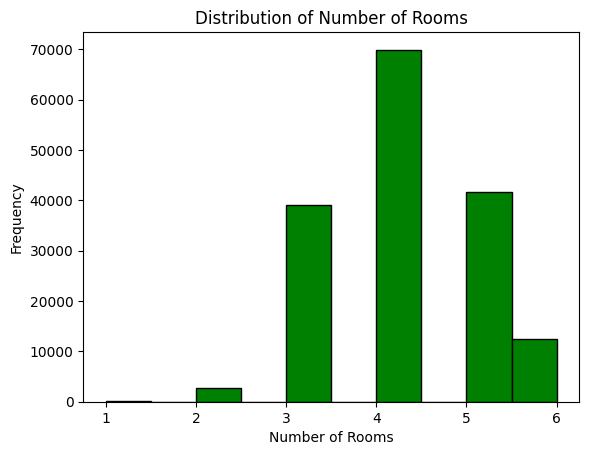

In [310]:
plt.hist(hdb_df['number_of_rooms'], bins=10, edgecolor='black', histtype= 'bar', color='green')
plt.title('Distribution of Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.show()

##### Scatter plot for 'floor_area_sqm' vs 'resale_price'

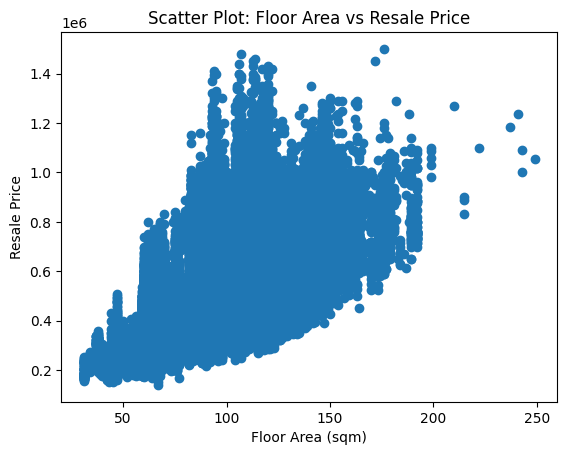

In [276]:
plt.scatter(hdb_df['floor_area_sqm'], hdb_df['resale_price'])
plt.title('Scatter Plot: Floor Area vs Resale Price')
plt.xlabel('Floor Area (sqm)')
plt.ylabel('Resale Price')
plt.show()


#### Let see the statistic information of the data

In [277]:
hdb_df.describe()

,number_of_rooms,storey,floor_area_sqm,remaining_lease,resale_price
count,166049.000000,166049.000000,166049.000000,166049.000000,1.660490e+05
mean,4.130961,9.767575,97.328697,74.699903,4.892796e+05
std,0.916981,5.948472,24.024204,13.828198,1.692389e+05
min,1.000000,3.000000,31.000000,42.250000,1.400000e+05
25%,3.000000,6.000000,82.000000,63.416667,3.650000e+05
50%,4.000000,9.000000,93.000000,74.666667,4.600000e+05
75%,5.000000,12.000000,112.000000,87.833333,5.800000e+05
max,6.000000,51.000000,249.000000,97.750000,1.500000e+06


In [278]:
# Assuming 'column_name' is the column with the issue
hdb_df['town'] = pd.to_numeric(hdb_df['town'], errors='coerce')

# Assuming df is your DataFrame
numeric_columns = hdb_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = hdb_df[numeric_columns].corr()

##### Let us see the relation between each parameters

<Axes: >

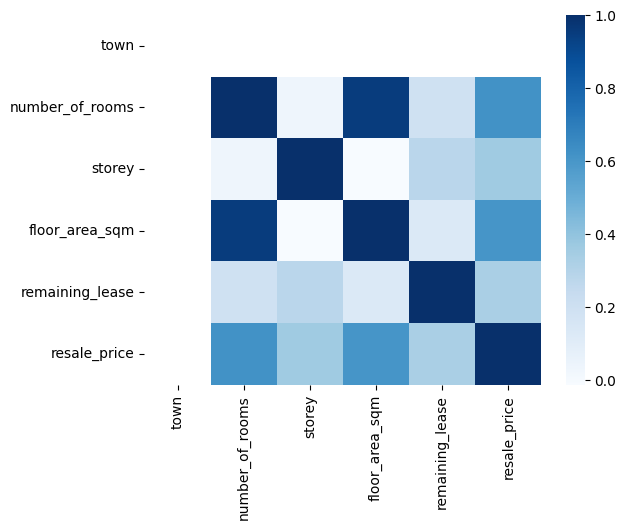

In [279]:
sns.heatmap(hdb_df.corr(), cmap="Blues")

## Machine Learning Models (Regression)
#### Let start to prepare the date for our machine learning model. My aim here is to determine which model has the highest accuracy in predicting the  resale price. The models I will compare are:

##### Multi Linear Regression
##### Lasso Regression
##### Elastic-Net Regression
##### Decision Tree
##### Random Forest

In [280]:
hdb_df['town'].unique()

array([nan])

In [281]:
hdb_df = hdb_df.replace(dict.fromkeys(['SEMBAWANG','SENGKANG','WOODLANDS','YISHUN'], 'NORTH'))
hdb_df = hdb_df.replace(dict.fromkeys(['BUKIT MERAH','BUKIT TIMAH','QUEENSTOWN'], 'SOUTH'))
hdb_df = hdb_df.replace(dict.fromkeys(['BEDOK','GEYLANG','HOUGANG','KALLANG/WHAMPOA','PASIR RIS','PUNGGOL','SERANGOON','TAMPINES'], 'EAST'))
hdb_df = hdb_df.replace(dict.fromkeys(['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST'], 'WEST'))
hdb_df = hdb_df.replace(dict.fromkeys(['ANG MO KIO','CENTRAL AREA','BISHAN','MARINE PARADE','TOA PAYOH'], 'CENTRAL'))

In [282]:
# Let's check whether the data replacement was done properly
hdb_df['town'].unique()

array([nan])

In [283]:
hdb_df = hdb_df.rename(columns={'town':'region'})

#### Simplification of categorical data using One Hot Encoder

In [284]:
X = hdb_df.iloc[:,:-1].values
y = hdb_df.iloc[:,-1].values

In [285]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [286]:
X[1,:]  

array([ 1.        ,  3.        ,  3.        , 67.        , 60.58333333])

#### Split the cleaned dataset into the Training set and Test set¶

In [287]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [288]:
# Import neccessary library to evaluate the performance of each machine learning model
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

#### Multi Linear Regression____________________

In [289]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_ypred = mlr.predict(X_test)
mlr_acc = r2_score(y_test,mlr_ypred)
mlr_acc

0.5277903674896878

#### Polynomial Regression_____________________

In [290]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Let's determine the best degree for polynomial
for n in range(2,5):
    poly_reg = PolynomialFeatures(degree = n)
    X_poly = poly_reg.fit_transform(X_train)
    pr = LinearRegression()
    pr.fit(X_poly, y_train)
    poly_ypred = pr.predict(poly_reg.transform(X_test))
    poly_acc = r2_score(y_test,poly_ypred)
    poly_rmse = np.sqrt(mean_squared_error(y_test,poly_ypred))
    print(r'The accuracy of polynomial regression with degree of {} is {}'.format(n,poly_acc))
    print(r'The RMSE of polynomial regression with degree of {} is {}'.format(n,poly_rmse))

The accuracy of polynomial regression with degree of 2 is 0.5816221858536264
The RMSE of polynomial regression with degree of 2 is 110086.2851172656
The accuracy of polynomial regression with degree of 3 is 0.5951652190471008
The RMSE of polynomial regression with degree of 3 is 108289.8624375127
The accuracy of polynomial regression with degree of 4 is 0.6058193486879098
The RMSE of polynomial regression with degree of 4 is 106855.4173037394


#### Ridge Regression_______________________

In [291]:
from sklearn.linear_model import Ridge
ridge_r = Ridge()
ridge_r.fit(X_train, y_train)
ridge_ypred = ridge_r.predict(X_test)
ridge_acc = r2_score(y_test,ridge_ypred)
ridge_acc

0.5277903431815566

#### Lasso Regression______________

In [292]:
from sklearn.linear_model import Lasso
lasso_r = Lasso(max_iter=100000)
lasso_r.fit(X_train, y_train)
lasso_ypred = lasso_r.predict(X_test)
lasso_acc = r2_score(y_test,lasso_ypred)
lasso_acc

0.5277904507923076

#### Elastic Net Regression____________________

In [293]:
from sklearn.linear_model import ElasticNet
EN_r = ElasticNet()
EN_r.fit(X_train, y_train)
EN_ypred = EN_r.predict(X_test)
EN_acc = r2_score(y_test,EN_ypred)
EN_acc

0.5256916906731175

#### Decision Tree Regression______________

In [294]:
from sklearn.tree import DecisionTreeRegressor
tree_r = DecisionTreeRegressor()
tree_r.fit(X_train, y_train)
tree_ypred = tree_r.predict(X_test)
tree_acc = r2_score(y_test,tree_ypred)
tree_acc

0.5253296574844144

#### Random Forest Regression___________________

In [295]:
from sklearn.ensemble import RandomForestRegressor
forest_r = RandomForestRegressor(n_estimators = 10)
forest_r.fit(X_train, y_train)
forest_ypred = forest_r.predict(X_test)
forest_acc = r2_score(y_test,forest_ypred)
forest_acc

0.6140402086429606

#### Comparison of different model based on R2-score and RMSE (Root Mean Square Error)

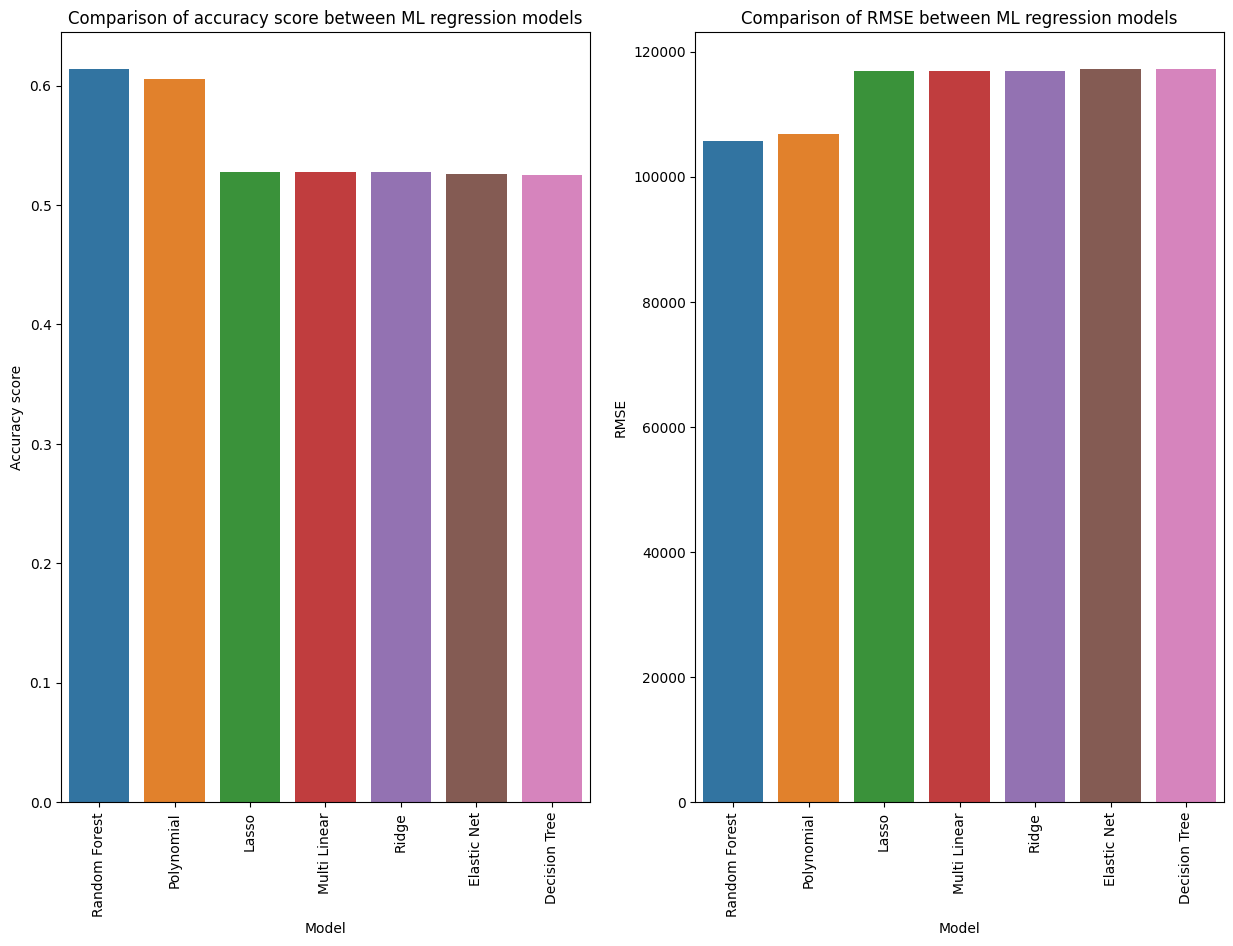

In [296]:
# Accuracy score for multi linear regression
mlr_acc = r2_score(y_test,mlr_ypred)
mlr_rmse = np.sqrt(mean_squared_error(y_test,mlr_ypred))

# Evaluation for polynomial regression has been calculated in finding the best degree
# Evaluation for ridge regression
ridge_acc = r2_score(y_test,ridge_ypred)
ridge_rmse = np.sqrt(mean_squared_error(y_test,ridge_ypred))

# Evaluation for lasso regression
lasso_acc = r2_score(y_test,lasso_ypred)
lasso_rmse = np.sqrt(mean_squared_error(y_test,lasso_ypred))

# Evaluation for elastic net regression
EN_acc = r2_score(y_test,EN_ypred)
EN_rmse = np.sqrt(mean_squared_error(y_test,EN_ypred))

# Evaluation for decision trees regression
tree_acc = r2_score(y_test,tree_ypred)
tree_rmse = np.sqrt(mean_squared_error(y_test,tree_ypred))

# Evaluation for elastic random forest regression
forest_acc = r2_score(y_test,forest_ypred)
forest_rmse = np.sqrt(mean_squared_error(y_test,forest_ypred))

# Let's put it as a list and compare it in a bar chart
model_acc_score = [mlr_acc,poly_acc, ridge_acc, lasso_acc, EN_acc, tree_acc, forest_acc]
model_rmse = [mlr_rmse, poly_rmse, ridge_rmse, lasso_rmse, EN_rmse, tree_rmse, forest_rmse]
model_list = ['Multi Linear', 'Polynomial', 'Ridge', 'Lasso', 'Elastic Net', 'Decision Tree', 'Random Forest']
model_result_df = pd.DataFrame(
    {'Model': model_list,
     'Accuracy score': model_acc_score,
     'RMSE': model_rmse
    })
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
sns.barplot(data=model_result_df, x='Model', y='Accuracy score', ax=ax1,order=model_result_df.sort_values('Accuracy score',ascending = False).Model).set_title("Comparison of accuracy score between ML regression models")
ax1 = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
sns.barplot(data=model_result_df, x='Model', y='RMSE', ax=ax2, order=model_result_df.sort_values('RMSE').Model).set_title("Comparison of RMSE between ML regression models")
ax2 = ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


In [297]:
area = ['Central', 'East', 'North', 'South', 'West']
features = [[0.0,  4, 9, 95.0, 75],
            [ 0.0, 4, 9, 95.0, 75],
            [ 0.0, 4, 9, 95.0, 75],
            [ 1.0,  4, 9, 95.0, 75],
            [0.0, 4, 9, 95.0, 75]]

# Make predictions for each area
resale_prices = [forest_r.predict([feature])[0] for feature in features]

# Create a DataFrame with the results

predict_df = pd.DataFrame(list(zip(area, resale_prices)),
                           columns=['Area', 'Predicted HDB price (SGD)'])
predict_df['Predicted HDB price (SGD)'] = predict_df['Predicted HDB price (SGD)'].round().astype(int)


In [298]:
predict_df['Predicted HDB price (SGD)']

0    580900
1    580900
2    580900
3    580900
4    580900
Name: Predicted HDB price (SGD), dtype: int32